# Predicting black hole masses from initial conditions

One of the primary targets of binary population synthesis is the final state of the two objects.
This is described in terms of the final mass of the two objects.
This can then be directly compared to the observed population of binary black hole mergers to test the assumptions of the model.

In COMPAS this involves simulating the full lifetime of the binary from initial stars to final objects.
In this challenge, you will learn a direct mapping from initial parameters to final masses.
We are specifically interested in binaries that result in a compact object binary.

Recommended methods:
- non-linear regression: the processes driving binary evolution are very non linear and so linear regression is not sufficient in this case (see below.)


In practice, there is some randomness to the evoution of the binary, for this reason, a probabilistic model may be able to better reproduce the behaviour of the detailed simulations.
In a later task, you will extend this method to use a probabilistic model that can map from either beginning to end state, or end to beginning.

In [20]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Load the data

For this we will use publicly available datasets from [zenodo](https://zenodo.org/records/6346444).
This data is a set of hdf5 files containing information about the initial state, evolution, and end state of the binaries.

Below we extract the initial system parameters and the final masses of the two objects.
These are stored in different attributes and because not every initial binary forms a compact binary, we merge on the `SEED` attribute that uniquely identifies each binary.

We remove some keys that aren't relevant for this task.
These are mostly a mixture of discrete flags and entries that are repeated.

In [21]:
DATADIR = Path("/project/dfreedman/colmt/UChicago-AI-in-Science-Hackathon/stellar-paleontology-data/")

ignore = [
    "Merges_Hubble_Time", "Recycled_NS(1)", "Unbound",
    "Time", "Merger", "Semi-Major_Axis", "Stellar_Type@ZAMS(1)",
    "Stellar_Type@ZAMS(2)", "Stellar_Type(1)", "Stellar_Type(2)",
    "SEED(OPTION)", "Recycled_NS(2)", "Initial_Mass(1)", "Initial_Mass(2)",
    "Metallicity", "Metallicity@ZAMS(2)", "CH_on_MS(1)", "CH_on_MS(2)",
]


with h5py.File(DATADIR / "Z_0.0001/COMPAS_Output.h5", "r") as ff:
    data = ff["BSE_Double_Compact_Objects"]
    double_compact_objects = pd.DataFrame.from_dict({
        key: data[key][()] for key in data
        if key not in ignore and np.ptp(data[key][()]) > 1e-5
    })
    data = ff["BSE_System_Parameters"]
    binary_parameters = pd.DataFrame.from_dict({
        key: data[key][()] for key in data if
        key not in ignore and np.ptp(data[key][()]) > 1e-5
    })

double_compact_objects = double_compact_objects.set_index("SEED")
binary_parameters = binary_parameters.set_index("SEED")
double_compact_objects = pd.concat([double_compact_objects, binary_parameters], axis=1, join="inner")
double_compact_objects.dropna(inplace=True)

double_compact_objects.describe()

,Coalescence_Time,Eccentricity@DCO,Mass(1),Mass(2),SemiMajorAxis@DCO,Kick_Magnitude_Random,Kick_Magnitude_Random(1),Kick_Magnitude_Random(2),Kick_Mean_Anomaly(1),Kick_Mean_Anomaly(2),Kick_Phi(1),Kick_Phi(2),Kick_Theta(1),Kick_Theta(2),Mass@ZAMS(1),Mass@ZAMS(2),SN_Kick_Magnitude_Random_Number(1),SN_Kick_Magnitude_Random_Number(2),SemiMajorAxis@ZAMS
count,1.109610e+05,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,1.109610e+05,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,1.109610e+05,110961.000000,110961.000000
mean,1.251656e+19,0.104010,26.331389,22.446476,292.395654,0.499020,4.939640e-01,0.486837,3.148422,3.136661,3.136783,3.143535,0.001399,-0.001696,64.743711,45.837560,4.939640e-01,0.486837,116.678805
std,8.988375e+19,0.207539,10.343956,10.072489,1679.044666,0.288427,2.896677e-01,0.290528,1.816093,1.813173,1.814506,1.814547,0.685264,0.682112,24.808291,18.519311,2.896677e-01,0.290528,209.975060
min,3.877147e-06,0.000001,1.260000,1.260000,0.002350,0.000009,7.103663e-07,0.000004,0.000002,0.000068,0.000130,0.000029,-1.565347,-1.559972,5.840793,5.051897,7.103663e-07,0.000004,0.058690
25%,3.174220e+05,0.002400,18.412500,15.736524,0.423640,0.249660,2.420687e-01,0.233117,1.575280,1.568266,1.567005,1.568197,-0.524684,-0.521543,45.316594,33.669820,2.420687e-01,0.233117,2.281854
50%,1.448906e+13,0.003828,24.884875,21.195135,34.102161,0.498874,4.891734e-01,0.481737,3.153669,3.137192,3.135265,3.146024,0.001928,-0.002592,58.797201,41.211901,4.891734e-01,0.481737,15.960135
75%,4.124895e+16,0.096352,34.025216,30.326078,267.818994,0.749177,7.452236e-01,0.737424,4.721037,4.713085,4.704509,4.719246,0.527124,0.518642,80.307607,54.605296,7.452236e-01,0.737424,117.138059
max,1.185659e+22,0.999785,238.908597,138.511441,306689.919089,1.000000,9.999927e-01,0.999986,6.283004,6.283141,6.283174,6.283024,1.569686,1.562202,149.935077,143.179735,9.999927e-01,0.999986,999.956433


## Look at the data

Before jumping in, remember to perform some visual checks on the data to build some intuition.

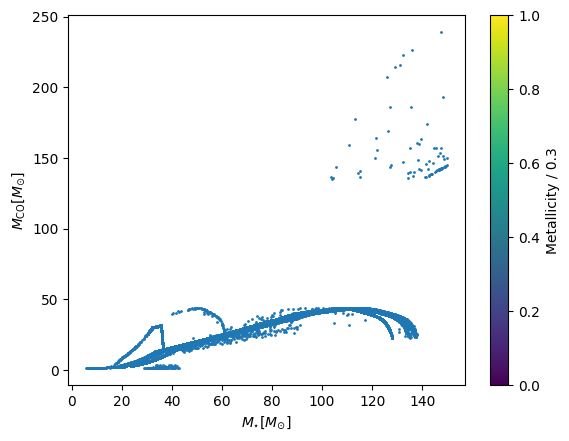

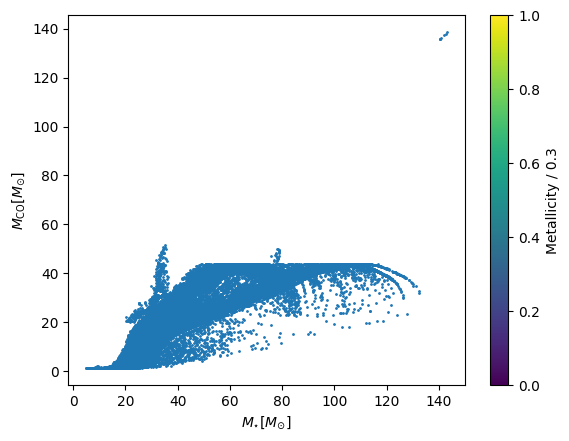

In [18]:
plt.scatter(double_compact_objects["Mass@ZAMS(1)"], double_compact_objects["Mass(1)"], s=1)
cbar = plt.colorbar()
plt.xlabel("$M_{\\star} [M_{\\odot}]$")
plt.ylabel("$M_{\\rm CO} [M_{\\odot}]$")
cbar.set_label("Metallicity / 0.3")
plt.show()
plt.close()

plt.scatter(double_compact_objects["Mass@ZAMS(2)"], double_compact_objects["Mass(2)"], s=1)
cbar = plt.colorbar()
plt.xlabel("$M_{\\star} [M_{\\odot}]$")
plt.ylabel("$M_{\\rm CO} [M_{\\odot}]$")
cbar.set_label("Metallicity / 0.3")
plt.show()
plt.close()

## Extract the initial state parameters

We need to extract the initial parameters so that we don't train on information we shouldn't have access to.
We can do this by extracting any parameters with `ZAMS`$^1$ or `Kick`$^2$ in the name.
We remove two parameters that enumerate the kind of star at the beginning of the simulation.

1. `ZAMS` (zero-age main sequence) marks when the stars form. Any quantities that are defined at this time are inputs to the simulation.
2. The kick refers to momentum that is lost during supernova explosions. Technically, these occur later in the simulation, but in practice they are chosen randomly based on some phenomenological prescription.

In [19]:
initial_parameters = pd.concat([
    double_compact_objects.filter(like="ZAMS"),
    double_compact_objects.filter(like="Kick"),
], join="inner", axis=1)
initial_parameters.describe()

,Mass@ZAMS(1),Mass@ZAMS(2),SemiMajorAxis@ZAMS,Kick_Magnitude_Random,Kick_Magnitude_Random(1),Kick_Magnitude_Random(2),Kick_Mean_Anomaly(1),Kick_Mean_Anomaly(2),Kick_Phi(1),Kick_Phi(2),Kick_Theta(1),Kick_Theta(2),SN_Kick_Magnitude_Random_Number(1),SN_Kick_Magnitude_Random_Number(2)
count,110961.000000,110961.000000,110961.000000,110961.000000,1.109610e+05,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,1.109610e+05,110961.000000
mean,64.743711,45.837560,116.678805,0.499020,4.939640e-01,0.486837,3.148422,3.136661,3.136783,3.143535,0.001399,-0.001696,4.939640e-01,0.486837
std,24.808291,18.519311,209.975060,0.288427,2.896677e-01,0.290528,1.816093,1.813173,1.814506,1.814547,0.685264,0.682112,2.896677e-01,0.290528
min,5.840793,5.051897,0.058690,0.000009,7.103663e-07,0.000004,0.000002,0.000068,0.000130,0.000029,-1.565347,-1.559972,7.103663e-07,0.000004
25%,45.316594,33.669820,2.281854,0.249660,2.420687e-01,0.233117,1.575280,1.568266,1.567005,1.568197,-0.524684,-0.521543,2.420687e-01,0.233117
50%,58.797201,41.211901,15.960135,0.498874,4.891734e-01,0.481737,3.153669,3.137192,3.135265,3.146024,0.001928,-0.002592,4.891734e-01,0.481737
75%,80.307607,54.605296,117.138059,0.749177,7.452236e-01,0.737424,4.721037,4.713085,4.704509,4.719246,0.527124,0.518642,7.452236e-01,0.737424
max,149.935077,143.179735,999.956433,1.000000,9.999927e-01,0.999986,6.283004,6.283141,6.283174,6.283024,1.569686,1.562202,9.999927e-01,0.999986


## Extact our regression target

As an initial test we are going to attempt to learn a one dimensional quantity, the final binary mass.
You will later fit a more complex target.

In [24]:
total_mass = double_compact_objects["Mass(1)"] + double_compact_objects["Mass(2)"]

## Run our regression

As a demsontration we fit a linear model.
We don't expect this to be particularly successful.

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
reg = LinearRegression().fit(initial_parameters, total_mass)
reg.score(initial_parameters, total_mass)

0.7907160551717707

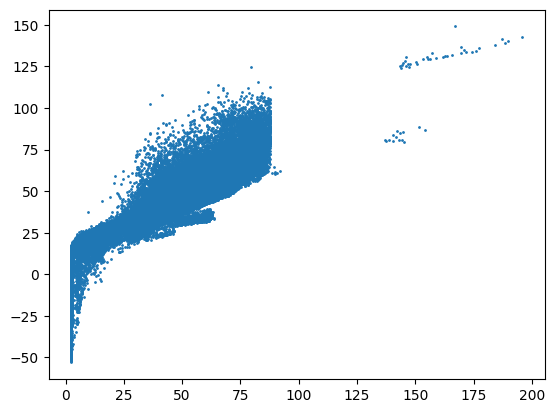

In [27]:
plt.scatter(total_mass, reg.predict(initial_parameters), s=1)
plt.show()
plt.close()

## Extensions

- Fit the two-dimensional final mass (`Mass(1)` and `Mass(2)`)
- Model all of the final state parameters, these are the final masses, `Coalescence_Time`, and anything with the `@DCO` label.
- Combine data with multiple metallicities and repeat the challenge.